In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `/data/gpfs/projects/punim0638/stephenz/QROT/notebooks/ex_lineage`


In [7]:
using Glob
using CSV
using DataFrames
using Plots
using StatsPlots
using StatsBase
using LaTeXStrings

[ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]


In [218]:
rank = 25
fnames_nys_proj_ent = Glob.glob("K_nys_$(rank)_proj_ent_*.csv")
fnames_proj_ent = Glob.glob("K_proj_ent_*.csv")
fnames_nys_proj_l2 = Glob.glob("K_nys_$(rank)_proj_l2_*.csv")
fnames_proj_l2 = Glob.glob("K_proj_l2_*.csv");

In [244]:
using LinearAlgebra
using PyCall
k = 25
sp_la = pyimport_conda("scipy.linalg", "scipy")
get_eigvecs(K, k) = eigen(Hermitian(I-K)).vectors[:, 1:k]
angles_ent = map(((x, y), ) -> sp_la.subspace_angles(get_eigvecs(Array(CSV.read(x, DataFrame)), k), 
                                    get_eigvecs(Array(CSV.read(y, DataFrame)), k)), Iterators.zip(fnames_nys_proj_ent, fnames_proj_ent));
angles_l2 = map(((x, y), ) -> sp_la.subspace_angles(get_eigvecs(Array(CSV.read(x, DataFrame)), k), 
                                    get_eigvecs(Array(CSV.read(y, DataFrame)), k)), Iterators.zip(fnames_nys_proj_l2, fnames_proj_l2));

In [245]:
eps_ent = [parse(Float64, split(splitext(x)[1], "_")[end]) for x in fnames_proj_ent];
eps_l2 = [parse(Float64, split(splitext(x)[1], "_")[end]) for x in fnames_proj_l2];

In [246]:
using LogExpFunctions
perplexity(K) = map(x -> exp(sum(-xlogx.(x))), eachrow(K))
perp_ent = [mean(perplexity(Array(CSV.read(y, DataFrame)))) for y in fnames_proj_ent];
perp_l2 = [mean(perplexity(Array(CSV.read(y, DataFrame)))) for y in fnames_proj_l2];

In [247]:
include("../../src/util.jl")
K = Array(CSV.read("K.csv", DataFrame))
angles_nys = sp_la.subspace_angles(get_eigvecs(Array(CSV.read("K_nys_$(rank).csv", DataFrame)), k), 
                      get_eigvecs(K, k));
perp_nys = mean(perplexity(norm_kernel(K, :row)))

462.1521939032482

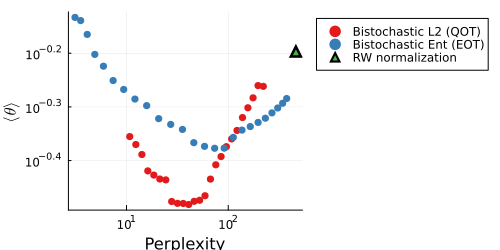

In [248]:
scatter(perp_l2, mean.(angles_l2), xscale = :log10, yscale = :log10, label = "Bistochastic L2 (QOT)", palette = :Set1_9, markerstrokewidth = 0, xlabel = "Perplexity", ylabel = L"$\langle \theta \rangle$", size = (500, 250), legend = :outertopright)
scatter!(perp_ent, mean.(angles_ent), label = "Bistochastic Ent (EOT)", markerstrokewidth = 0)
scatter!([perp_nys,], [mean(angles_nys), ], label = "RW normalization", marker = :^, markerstrokewidth = 5, markersize = 5)